# XGBoost con codificación ordinal

## 1. Introducción

En este notebook implementamos un modelo XGBoost para predecir el
rendimiento global de estudiantes.

Aplicamos codificación ordinal con LabelEncoder, limpieza de datos, y
entrenamiento con validación cruzada.

## 2. Preprocesamiento

### 2.1. Carga de datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [ ]:
file_id_train = '1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY'
gdown.download(f'https://drive.google.com/uc?id={file_id_train}', 'train.csv', quiet=False)
df = pd.read_csv("train.csv")
print("Datos de entrenamiento 'train.csv' cargados exitosamente.")

file_id_test = '1KrH-u4UU1e_Ha7cFuCZOB7ZT4tEUQ2ex'
gdown.download(f'https://drive.google.com/uc?id={file_id_test}', 'test.csv', quiet=False)
df_test = pd.read_csv("test.csv")
print("Datos de prueba 'test.csv' cargados exitosamente.")

Downloading...
From (original): https://drive.google.com/uc?id=1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY
From (redirected): https://drive.google.com/uc?id=1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY&confirm=t&uuid=c0e37640-bc7d-4c7c-b928-b01e40942cf0
To: /content/train.csv
100%|██████████| 144M/144M [00:01<00:00, 90.5MB/s]


Datos de entrenamiento 'train.csv' cargados exitosamente.


Downloading...
From: https://drive.google.com/uc?id=1KrH-u4UU1e_Ha7cFuCZOB7ZT4tEUQ2ex
To: /content/test.csv
100%|██████████| 59.2M/59.2M [00:00<00:00, 93.1MB/s]


Datos de prueba 'test.csv' cargados exitosamente.


### 2.2. Limpieza de datos (valores faltantes)

In [ ]:
# Eliminar columna duplicada
if 'FAMI_TIENEINTERNET.1' in df.columns:
    df.drop(columns=['FAMI_TIENEINTERNET.1'], inplace=True)
    print("Columna 'FAMI_TIENEINTERNET.1' eliminada del DataFrame de entrenamiento.")
if 'FAMI_TIENEINTERNET.1' in df_test.columns:
    df_test.drop(columns=['FAMI_TIENEINTERNET.1'], inplace=True)
    print("Columna 'FAMI_TIENEINTERNET.1' eliminada del DataFrame de prueba.")

# Imputaciones de valores faltantes (aplicar a ambos DataFrames)
missing_replacements = {
    'ESTU_VALORMATRICULAUNIVERSIDAD': 'Sin información',
    'ESTU_HORASSEMANATRABAJA': 'Sin información',
    'FAMI_ESTRATOVIVIENDA': 'Sin información',
    'FAMI_EDUCACIONPADRE': 'No sabe / No responde',
    'FAMI_EDUCACIONMADRE': 'No sabe / No responde',
    'FAMI_TIENECOMPUTADOR': 'Sin información',
    'FAMI_TIENEINTERNET': 'Sin información',
    'FAMI_TIENEAUTOMOVIL': 'Sin información'
}
for col, value in missing_replacements.items():
    if col in df.columns:
        df[col] = df[col].fillna(value)
    if col in df_test.columns:
        df_test[col] = df_test[col].fillna(value)
print("Imputaciones de valores faltantes completadas.")

# Imputaciones con moda (calcular la moda del TRAIN set y aplicarla a ambos)
mode_columns = ['FAMI_TIENELAVADORA', 'ESTU_PAGOMATRICULAPROPIO']
for col in mode_columns:
    if col in df.columns:
        moda = df[col].mode()[0]
        df[col] = df[col].fillna(moda)
    if col in df_test.columns:
        df_test[col] = df_test[col].fillna(moda)
print("Imputaciones de valores faltantes por moda completadas.")

# Separación de Datos
test_ids = df_test['ID']

y = df['RENDIMIENTO_GLOBAL']
df_features = df.drop(columns=['RENDIMIENTO_GLOBAL', 'ID', 'PERIODO', 'coef_1', 'coef_2', 'coef_3'], errors='ignore')

X_test_submission_raw = df_test.drop(columns=['ID', 'PERIODO', 'coef_1', 'coef_2', 'coef_3'], errors='ignore')

# División para validación interna
X_train, X_test, y_train_raw, y_test_raw = train_test_split(df_features, y, test_size=0.2, random_state=42)
print("\nDatos divididos en conjuntos de entrenamiento y prueba para validación interna.")

# Codificación numérica de la variable objetivo 'RENDIMIENTO_GLOBAL'
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)

Columna 'FAMI_TIENEINTERNET.1' eliminada del DataFrame de entrenamiento.
Columna 'FAMI_TIENEINTERNET.1' eliminada del DataFrame de prueba.
Imputaciones de valores faltantes completadas.
Imputaciones de valores faltantes por moda completadas.

Datos divididos en conjuntos de entrenamiento y prueba para validación interna.


### 2.3. Codificacion Ordinal



In [ ]:
categorical_ordered_features = {
    'FAMI_ESTRATOVIVIENDA': ['Sin información', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6'],
    'FAMI_EDUCACIONPADRE': ['No sabe / No responde', 'Ninguno', 'Primaria incompleta', 'Primaria completa',
                            'Secundaria incompleta', 'Secundaria completa', 'Técnica o tecnológica incompleta',
                            'Técnica o tecnológica completa', 'Profesional incompleta', 'Profesional completa',
                            'Postgrado'],
    'FAMI_EDUCACIONMADRE': ['No sabe / No responde', 'Ninguno', 'Primaria incompleta', 'Primaria completa',
                            'Secundaria incompleta', 'Secundaria completa', 'Técnica o tecnológica incompleta',
                            'Técnica o tecnológica completa', 'Profesional incompleta', 'Profesional completa',
                            'Postgrado'],
    'ESTU_VALORMATRICULAUNIVERSIDAD': ['Sin información', 'No pagó matrícula', 'Menos de 1 millón', 'Entre 1 millón y 2.5 millones',
                                        'Entre 2.5 millones y 4 millones', 'Entre 4 millones y 5.5 millones',
                                        'Entre 5.5 millones y 7 millones', 'Más de 7 millones'],
    'ESTU_HORASSEMANATRABAJA': ['Sin información', 'No', 'Menos de 10 horas', 'Entre 10 y 20 horas',
                                 'Entre 20 y 30 horas', 'Más de 30 horas'],
    'FAMI_TIENECOMPUTADOR': ['Sin información', 'No', 'Si'],
    'FAMI_TIENEINTERNET': ['Sin información', 'No', 'Si'],
    'FAMI_TIENELAVADORA': ['No', 'Si'],
    'FAMI_TIENEAUTOMOVIL': ['Sin información', 'No', 'Si'],
    'ESTU_PAGOMATRICULAPROPIO': ['No', 'Si']
}

for col, categories in categorical_ordered_features.items():
    if col in X_train.columns:
        encoder = OrdinalEncoder(categories=[categories], handle_unknown='use_encoded_value', unknown_value=-1)
        X_train[col] = encoder.fit_transform(X_train[[col]].astype(str))
        X_test[col] = encoder.transform(X_test[[col]].astype(str))
        if col in X_test_submission_raw.columns:
            X_test_submission_raw[col] = encoder.transform(X_test_submission_raw[[col]].astype(str))
print("\nCodificación Ordinal aplicada.")

binary_mappings = {
    'ESTU_GENERO': {'F': 0, 'M': 1},
    'COLE_BILINGUE': {'N': 0, 'S': 1},
    'ESTU_PRIVADO_LIBERTAD': {'S': 1, 'N': 0}
}

for col, mapping in binary_mappings.items():
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(str).map(mapping).fillna(-1)
        X_test[col] = X_test[col].astype(str).map(mapping).fillna(-1)
        if col in X_test_submission_raw.columns:
            X_test_submission_raw[col] = X_test_submission_raw[col].astype(str).map(mapping).fillna(-1)
        print(f"Columna '{col}' mapeada a valores binarios.")
    else:
        print(f"Advertencia: La columna binaria '{col}' no se encontró.")

for col in X_train.select_dtypes(include='object').columns:
    print(f"Convirtiendo columna '{col}' a tipo 'category' para XGBoost.")
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    if col in X_test_submission_raw.columns:
        X_test_submission_raw[col] = X_test_submission_raw[col].astype('category')


Codificación Ordinal aplicada.
Advertencia: La columna binaria 'ESTU_GENERO' no se encontró.
Advertencia: La columna binaria 'COLE_BILINGUE' no se encontró.
Columna 'ESTU_PRIVADO_LIBERTAD' mapeada a valores binarios.
Convirtiendo columna 'ESTU_PRGM_ACADEMICO' a tipo 'category' para XGBoost.
Convirtiendo columna 'ESTU_PRGM_DEPARTAMENTO' a tipo 'category' para XGBoost.


### 2.4. Normalización de variables numéricas

In [ ]:
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
X_test_submission_raw[numeric_cols] = scaler.transform(X_test_submission_raw[numeric_cols])

print("\nVariables numéricas normalizadas.")

X_train_final = X_train
X_test_final = X_test
X_test_submission_final = X_test_submission_raw
print("\nDatos finales para el modelo y submission preparados.")


Variables numéricas normalizadas.

Datos finales para el modelo y submission preparados.


## 3. Modelo de Machine Learning

### 3.1. Configuración del modelo SVM

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.7,
    colsample_bytree=0.7,
    use_label_encoder=False,
    random_state=42,
    enable_categorical=True
)

### 3.2. Entrenamiento del modelo SVM

In [ ]:
print("\nEntrenando modelo XGBoost...")
xgb_model.fit(X_train_final, y_train)
print("Modelo XGBoost entrenado exitosamente.")


Entrenando modelo XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:22:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Modelo XGBoost entrenado exitosamente.


### 3.3. Evaluación del modelo

In [ ]:
print("\n--- Métricas de Evaluación del Modelo XGBoost ---")
y_pred = xgb_model.predict(X_test_final)
y_pred_proba = xgb_model.predict_proba(X_test_final)

print(f"Accuracy en test: {accuracy_score(y_test, y_pred):.4f}")
print("\nReporte de Clasificación en test:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\nMatriz de Confusión en test:")
print(confusion_matrix(y_test, y_pred))

print(f"\nAUC-ROC Score en test (OVR, weighted): {roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'):.4f}")


--- Métricas de Evaluación del Modelo XGBoost ---
Accuracy en test: 0.3314

Reporte de Clasificación en test:
              precision    recall  f1-score   support

        alto       0.44      0.38      0.41     35165
        bajo       0.35      0.44      0.39     34573
  medio-alto       0.27      0.26      0.26     34259
  medio-bajo       0.26      0.25      0.26     34503

    accuracy                           0.33    138500
   macro avg       0.33      0.33      0.33    138500
weighted avg       0.33      0.33      0.33    138500


Matriz de Confusión en test:
[[13227  6675  7883  7380]
 [ 3991 15335  7289  7958]
 [ 7478  9538  8764  8479]
 [ 5333 12216  8377  8577]]

AUC-ROC Score en test (OVR, weighted): 0.5971


## 4. Generación de predicciones y exportación

### 4.1 Alineacion de columnas

In [ ]:
# Para que coincidan exactamente con las columnas usadas para entrenar el modelo.
X_test_submission_final = X_test_submission_final.reindex(columns=X_train_final.columns, fill_value=0)

# Asegurarse de que las columnas 'category' sigan siendo 'category' después del reindex.
for col in X_train_final.select_dtypes(include='category').columns:
    if col in X_test_submission_final.columns:
        X_test_submission_final[col] = X_test_submission_final[col].astype('category')

print("\nColumnas del dataset de prueba (para submission) alineadas.")


Columnas del dataset de prueba (para submission) alineadas.


### 4.2 Predicciones

In [ ]:
y_pred_test_submission_encoded = xgb_model.predict(X_test_submission_final)

In [ ]:
y_pred_test_submission = label_encoder.inverse_transform(y_pred_test_submission_encoded)
print("Predicciones para 'test.csv' generadas y revertidas a etiquetas originales.")

Predicciones para 'test.csv' generadas y revertidas a etiquetas originales.


In [ ]:
from sklearn.metrics import accuracy_score

# Calculamos el accuracy en el conjunto de validación
y_val_pred_xgb = xgb_model.predict(X_test_final)
accuracy_xgb = accuracy_score(y_test, y_val_pred_xgb)
print(f"🎯 Accuracy - XGBoost: {accuracy_xgb:.4f}")

🎯 Accuracy - XGBoost: 0.3314


### 4.3. Visualización

🎯 Distribución de clases predichas (XGBoost):
0    30029
1    43764
2    32313
3    32394
Name: count, dtype: int64


/tmp/ipython-input-19-2631083264.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_counts_xgb.index, y=pred_counts_xgb.values, palette="coolwarm")


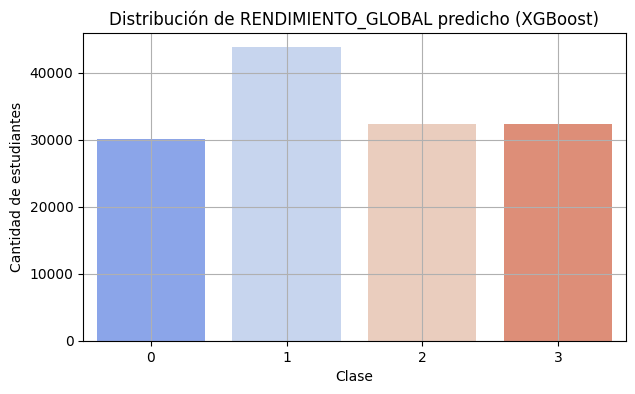

<Figure size 700x600 with 0 Axes>

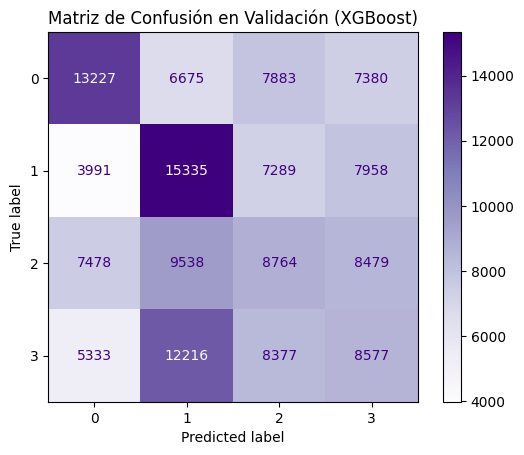

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tabla de distribución de clases predichas
pred_counts_xgb = pd.Series(y_val_pred_xgb).value_counts().sort_index()
print("🎯 Distribución de clases predichas (XGBoost):")
print(pred_counts_xgb)

# Gráfico de barras
plt.figure(figsize=(7, 4))
sns.barplot(x=pred_counts_xgb.index, y=pred_counts_xgb.values, palette="coolwarm")
plt.title("Distribución de RENDIMIENTO_GLOBAL predicho (XGBoost)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de estudiantes")
plt.grid(True)
plt.show()

# Matriz de confusión
cm_xgb = confusion_matrix(y_test, y_val_pred_xgb, labels=xgb_model.classes_)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_model.classes_)
plt.figure(figsize=(7, 6))
disp_xgb.plot(cmap="Purples", values_format='d')
plt.title("Matriz de Confusión en Validación (XGBoost)")
plt.grid(False)
plt.show()

### 4.5. Envío a Kaggle

In [ ]:
# Generar el archivo de submission
submission_xgb = pd.DataFrame({
    'ID': df_test['ID'],
    'RENDIMIENTO_GLOBAL': label_encoder.inverse_transform(y_pred_test_submission_encoded)
})
submission_xgb.to_csv('solution.csv', index=False)
print("🎯 XGBoost: archivo 'solution.csv' generado")

🎯 XGBoost: archivo 'solution.csv' generado


## 5. Conclusiones

- El modelo XGBoost alcanzó un accuracy de 0.35347 en Kaggle.
- Es un modelo eficiente y rápido, capaz de manejar datos faltantes sin imputación adicional y de capturar relaciones no lineales.
- Sin embargo, el resultado indica que todavía hay margen de mejora, posiblemente añadiendo optimización de hiperparámetros o combinándolo con técnicas como selección de características o codificaciones más expresivas.